Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import artm


ModuleNotFoundError: No module named 'artm'

In [4]:
import tqdm

Сохраним список стоп-слов для русского языка и расширим его (из файлика stopwords-ru.txt для many-stop-words 0.2.2)

In [9]:
stop_words = nltk.corpus.stopwords.words('russian')
stop_words.extend(pd.read_table("./stopwords-ru.txt"))

In [10]:
stop_words

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [6]:
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [37]:
test_df = pd.read_csv('sample_submission.csv')

Воспользуемся тем, что текст мы предварительно подготовили и очистили от html-тэгов, знаков препинания и json   
Загрузим сохраненные данные из файла, причем переведем текст к строчным буквам.

In [38]:
df = pd.read_pickle('baseline_lemmatized_dataset')
df.cleared_text = df.cleared_text.apply(lambda x : x.lower())
df.set_index('post_id', inplace=True)

In [40]:
df.head()

,published_at,feature_text,cleared_text,lemmatized_text
post_id,,,,
1,2017-01-01T00:05:00Z,Полиция Стамбула собирается штурмовать ночной ...,полиция стамбула собирается штурмовать ночной ...,полиция стамбул собираться штурмовать ...
2,2017-01-01T00:07:00Z,Расстрел посетителей в ночном клубе в Стамбуле...,расстрел посетителей в ночном клубе в стамбуле...,расстрел посетитель в ночной клуб в ...
3,2017-01-01T00:21:00Z,Губернатор Стамбула: При нападении на ночной к...,губернатор стамбула при нападении на ночной кл...,губернатор стамбул при нападение на ...
4,2017-01-01T00:29:00Z,Губернатор Стамбула назвал террористической ат...,губернатор стамбула назвал террористической ат...,губернатор стамбул называть террористиче...
5,2017-01-01T00:47:00Z,Очевидцы: В ночной клуб в Стамбуле проходили б...,очевидцы в ночной клуб в стамбуле проходили бе...,очевидец в ночной клуб в стамбул п...


Добавим слова из обработанного текста в множество данных для bigartm, если эти слова не входят в набор стоп-слов.

In [42]:
with open('baseline_bigartm_dataset_input.txt', 'a', encoding='utf-8') as f:
    for index in tqdm.tqdm_notebook(df.index):
        c = len([it for it in df.loc[index].lemmatized_text.split(' ') if (it not in stop_words) & it.isalpha() & (len(it)>2)])
        f.write('doc{0} '.format(index)\
                +' '.join(['{0}:{1}'.format(it, float(count)) for it, count in c.items()])\
                + '\n'\
               )

HBox(children=(IntProgress(value=0, max=103327), HTML(value='')))

Для того, чтобы перевести данные из файла, записанного ранее (в формате Vowpal Wabbit, доступном для чтения в artm модель (NB! описание формата:   
    каждый документ - отдельной строкой   
    все токены представляют собой строки    
    частота токенов по умолчанию соствляет 1 и может быть уточнена через двоеточие (как, собственно, мы и записали)   
    )  воспользуемся конвертором


In [43]:
batch_vectorizer = artm.BatchVectorizer(data_path='baseline_bigartm_dataset_input.txt',\
                                        data_format='vowpal_wabbit',\
                                        target_folder='bbd_batches'\
                                       )

А теперь получим artm модель по созданному ранее словарю. Кроме того, добавим к модели следующие регуляризаторы и обучим её.

In [64]:
artm_model = artm.ARTM(num_topics=100, cache_theta=True,
               num_document_passes=25, dictionary=batch_vectorizer.dictionary,\
               num_processors=4,\
               scores=[artm.TopTokensScore(name='top_tokens_score'),\
                       artm.PerplexityScore(name = 'perplexity'),\
                       artm.SparsityThetaScore(name='SparsityThetaScore'),\
                       artm.TipikKernelScore(name ='TopikKernelScore')\
                      ])
artm_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.005))
artm_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.01))

In [66]:
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Объявим функцию для отрисовки результатов растерянности в зависимости от числа тем и числа эпох

In [19]:
def plot_value_tracker(track_object, tracker_name):
    plt.plot(track_object.value)
    plt.title('{0} of model with {1} topics and {2} doc_epochs'.format(tracker_name,25, 20))
    plt.ylabel(tracker_name)
    plt.xlabel('Collection Epochs')
    plt.show()

И построим графики для интересующих нас параметров полученной модели.

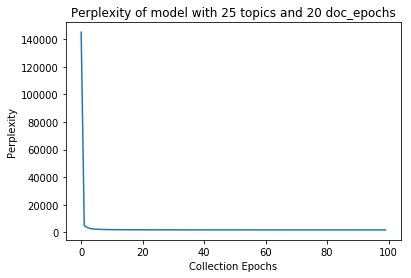

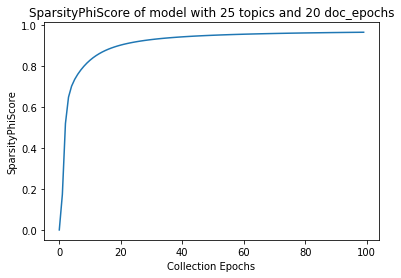

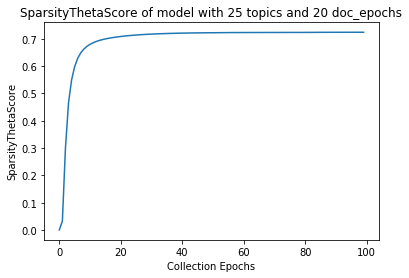

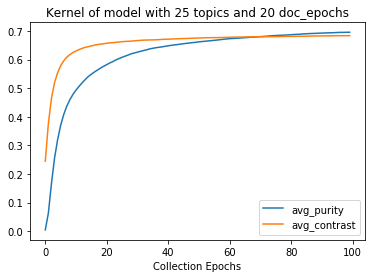

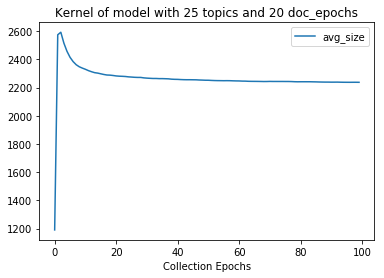

In [177]:
perp = artm_model.score_tracker['perplexity']
plot_value_tracker(perp, 'Perplexity')
phi = artm_model.score_tracker['SparsityPhiScore']
plot_value_tracker(phi, 'SparsityPhiScore')
theta = artm_model.score_tracker['SparsityThetaScore']
plot_value_tracker(theta, 'SparsityThetaScore')
kernel = artm_model.score_tracker['TopicKernelScore']

In [52]:
doc_topic_matrix_artm = artm_model.get_theta().T

In [171]:
for test_it in test_df.index:
    needed_pair = [int(it)-1 for it in test_df.loc[test_it].id.split('_')]
    corr = doc_topic_matrix.loc[needed_pair].T.corr().at[needed_pair[0], needed_pair[1]]
    test_df.at[test_it, 'similarity'] = corr

In [178]:
perp.last_value, phi.last_value, theta.last_value

(1765.1483154296875, 0.964113712310791, 0.7240685224533081)

In [179]:
artm_model.save('baseline_artm_100_topics')